# Bitcoin price Prediction using LSTM

# Importing Library

In [ ]:
import os
import pandas as pd
import yfinance as yf
import numpy as np
import math
import datetime as dt
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Loading Dataset

In [3]:
df = yf.Ticker("BTC-USD").history(period="max", auto_adjust=False)
df.index = pd.to_datetime(df.index)
df.reset_index(inplace=True)
df.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)

In [4]:
print('Total number of days present in the dataset: ',df.shape[0])
print('Total number of fields present in the dataset: ',df.shape[1])

Total number of days present in the dataset:  3961
Total number of fields present in the dataset:  9


In [5]:
df.shape

(3961, 9)

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj_Close,Volume,Dividends,Stock Splits
0,2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,0.0,0.0
1,2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,0.0,0.0
2,2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,0.0,0.0
3,2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,0.0,0.0
4,2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,0.0,0.0


In [7]:
df.tail()

,Date,Open,High,Low,Close,Adj_Close,Volume,Dividends,Stock Splits
3956,2025-07-17 00:00:00+00:00,118738.507812,120999.609375,117508.218750,119289.843750,119289.843750,72363841798,0.0,0.0
3957,2025-07-18 00:00:00+00:00,119284.109375,120851.914062,116925.984375,118003.226562,118003.226562,77945799785,0.0,0.0
3958,2025-07-19 00:00:00+00:00,117998.125000,118541.398438,117388.414062,117939.976562,117939.976562,47564562765,0.0,0.0
3959,2025-07-20 00:00:00+00:00,117944.109375,118865.031250,116550.132812,117300.789062,117300.789062,57515447231,0.0,0.0
3960,2025-07-22 00:00:00+00:00,117419.648438,117928.304688,116653.648438,116972.429688,116972.429688,69301395456,0.0,0.0


In [8]:
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3961 entries, 0 to 3960
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   Date          3961 non-null   datetime64[ns, UTC]
 1   Open          3961 non-null   float64            
 2   High          3961 non-null   float64            
 3   Low           3961 non-null   float64            
 4   Close         3961 non-null   float64            
 5   Adj_Close     3961 non-null   float64            
 6   Volume        3961 non-null   int64              
 7   Dividends     3961 non-null   float64            
 8   Stock Splits  3961 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(7), int64(1)
memory usage: 278.6 KB


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume',
       'Dividends', 'Stock Splits'],
      dtype='object')

In [9]:
df.describe()

,Open,High,Low,Close,Adj_Close,Volume,Dividends,Stock Splits
count,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3.961000e+03,3961.0,3961.0
mean,23552.636251,24054.893827,23030.469692,23580.886245,23580.886245,1.998823e+10,0.0,0.0
std,27659.605409,28191.699559,27116.144418,27695.698750,27695.698750,2.134409e+10,0.0,0.0
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06,0.0,0.0
25%,2288.330078,2397.169922,2183.219971,2304.979980,2304.979980,9.499790e+08,0.0,0.0
50%,10115.559570,10295.668945,9734.559570,10116.673828,10116.673828,1.610072e+10,0.0,0.0
75%,37721.414062,38834.617188,36750.128906,37750.453125,37750.453125,3.133871e+10,0.0,0.0
max,119853.851562,123091.609375,118959.195312,119849.703125,119849.703125,3.509679e+11,0.0,0.0


# Checking for Null Values

In [10]:
print('Null Values:',df.isnull().values.sum())

Null Values: 0


In [11]:
print('NA values:',df.isnull().values.any())

NA values: False


In [12]:
df.shape

(3961, 9)

# EDA(Exploratory Data Analysis)

In [13]:
sd=df.iloc[0][0]
ed=df.iloc[-1][0]


print('Starting Date',sd)
print('Ending Date',ed)


Starting Date 2014-09-17 00:00:00+00:00
Ending Date 2025-07-22 00:00:00+00:00


/var/folders/2z/b4nb34mn4vb203chvsvh7x7m0000gn/T/ipykernel_17161/2310875056.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sd=df.iloc[0][0]
/var/folders/2z/b4nb34mn4vb203chvsvh7x7m0000gn/T/ipykernel_17161/2310875056.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ed=df.iloc[-1][0]


# Analysis of year 2014

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')


y_2014 = df.loc[(df['Date'] >= '2014-09-17')
                     & (df['Date'] < '2014-12-31')]

y_2014.drop(y_2014[['Adj_Close','Volume']],axis=1)

,Date,Open,High,Low,Close,Dividends,Stock Splits
0,2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,0.0,0.0
1,2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,0.0,0.0
2,2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,0.0,0.0
3,2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,0.0,0.0
4,2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,0.0,0.0
...,...,...,...,...,...,...,...
100,2014-12-26 00:00:00+00:00,319.152008,331.424011,316.627014,327.924011,0.0,0.0
101,2014-12-27 00:00:00+00:00,327.583008,328.911011,312.630005,315.863007,0.0,0.0
102,2014-12-28 00:00:00+00:00,316.160004,320.028015,311.078003,317.239014,0.0,0.0
103,2014-12-29 00:00:00+00:00,317.700989,320.266998,312.307007,312.670013,0.0,0.0


In [15]:
monthvise= y_2014.groupby(y_2014['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,NaN,NaN
February,NaN,NaN
March,NaN,NaN
April,NaN,NaN
May,NaN,NaN
June,NaN,NaN
July,NaN,NaN
August,NaN,NaN
September,412.654003,407.182428


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Bitcoin Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Bitcoin Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparison between Bitcoin open and close price')
fig.show()

In [17]:
y_2014.groupby(y_2014['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2014.groupby(df['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2014.groupby(y_2014['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Bitcoin high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Bitcoin low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low Bitcoin price')
fig.show()

In [18]:
names = cycle(['Bitcoin Open Price','Bitcoin Close Price','Bitcoin High Price','Bitcoin Low Price'])

fig = px.line(y_2014, x=y_2014.Date, y=[y_2014['Open'], y_2014['Close'], 
                                          y_2014['High'], y_2014['Low']],
             labels={'Date': 'Date','value':'Bitcoin value'})
fig.update_layout(title_text='Bitcoin analysis chart', font_size=15, font_color='black',legend_title_text='Bitcoin Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# 2nd Bitcoin Halving

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

y_2015 = df.loc[(df['Date'] >= '2012-11-28')
                        & (df['Date'] < '2016-09-09')]

y_2015.drop(y_2015[['Adj_Close','Volume']],axis=1)

,Date,Open,High,Low,Close,Dividends,Stock Splits
0,2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,0.0,0.0
1,2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,0.0,0.0
2,2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,0.0,0.0
3,2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,0.0,0.0
4,2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,0.0,0.0
...,...,...,...,...,...,...,...
718,2016-09-04 00:00:00+00:00,598.590027,611.836975,596.848022,608.633972,0.0,0.0
719,2016-09-05 00:00:00+00:00,608.989990,609.054993,602.242004,606.590027,0.0,0.0
720,2016-09-06 00:00:00+00:00,606.505981,610.830017,605.091003,610.435974,0.0,0.0
721,2016-09-07 00:00:00+00:00,610.572998,614.544983,608.513000,614.544006,0.0,0.0


In [20]:
monthvise = y_2015.groupby(y_2015['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,332.302904,329.813516
February,319.049966,320.774421
March,343.270226,342.784016
April,334.598050,334.915466
May,348.199677,349.475708
June,437.743134,440.475414
July,470.917729,470.459921
August,417.112870,415.159501
September,337.395443,336.942152


In [21]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [22]:
y_2015.groupby(y_2015['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2015.groupby(df['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2015.groupby(y_2015['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [23]:
model = LinearRegression()
X = np.arange(len(y_2015)).reshape(-1, 1)
y = y_2015['Close']
model.fit(X, y)

y_2015['Predicted'] = model.predict(X)

names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price','Predicted Price'])

fig = px.line(y_2015, x=y_2015.Date, y=[y_2015['Open'], y_2015['Close'], 
                                          y_2015['High'], y_2015['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.add_scatter(
    x=y_2015['Date'],
    y=y_2015['Predicted'],
    mode='lines',
    name='Predicted Price',
    line=dict(color='blue', dash='dot')
)
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

/var/folders/2z/b4nb34mn4vb203chvsvh7x7m0000gn/T/ipykernel_17161/3576084021.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# 3rd Bitcoin Halving

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

y_2015 = df.loc[(df['Date'] >= '2016-09-09')
                        & (df['Date'] < '2020-05-11')]

y_2015.drop(y_2015[['Adj_Close','Volume']],axis=1)

,Date,Open,High,Low,Close,Dividends,Stock Splits
723,2016-09-09 00:00:00+00:00,626.351990,626.830017,620.263000,622.861023,0.0,0.0
724,2016-09-10 00:00:00+00:00,622.927002,625.094971,622.395020,623.508972,0.0,0.0
725,2016-09-11 00:00:00+00:00,623.424011,628.817993,600.505981,606.718994,0.0,0.0
726,2016-09-12 00:00:00+00:00,607.005005,608.458984,605.411011,608.242981,0.0,0.0
727,2016-09-13 00:00:00+00:00,608.025024,611.192993,606.924988,609.241028,0.0,0.0
...,...,...,...,...,...,...,...
2058,2020-05-06 00:00:00+00:00,9007.441406,9411.467773,8966.706055,9268.761719,0.0,0.0
2059,2020-05-07 00:00:00+00:00,9261.895508,9992.664062,9138.322266,9951.518555,0.0,0.0
2060,2020-05-08 00:00:00+00:00,9936.162109,9996.743164,9767.172852,9842.666016,0.0,0.0
2061,2020-05-09 00:00:00+00:00,9840.906250,9913.863281,9580.644531,9593.896484,0.0,0.0


In [25]:
monthvise = y_2015.groupby(y_2015['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,6538.852608,6522.824922
February,6000.454825,6001.693113
March,5300.262926,5254.251885
April,5362.172487,5410.796100
May,6182.851701,6207.943371
June,6266.437210,6281.870730
July,6767.461913,6778.368177
August,7067.119718,7074.789435
September,5626.129825,5607.591639


In [26]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [27]:
y_2015.groupby(y_2015['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2015.groupby(df['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2015.groupby(y_2015['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [28]:
model = LinearRegression()
X = np.arange(len(y_2015)).reshape(-1, 1)
y = y_2015['Close']
model.fit(X, y)

y_2015['Predicted'] = model.predict(X)

names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price','Predicted Price'])

fig = px.line(y_2015, x=y_2015.Date, y=[y_2015['Open'], y_2015['Close'], 
                                          y_2015['High'], y_2015['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.add_scatter(
    x=y_2015['Date'],
    y=y_2015['Predicted'],
    mode='lines',
    name='Predicted Price',
    line=dict(color='blue', dash='dot')
)
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

/var/folders/2z/b4nb34mn4vb203chvsvh7x7m0000gn/T/ipykernel_17161/3576084021.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# 4th Bitcoin halving

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

y_2015 = df.loc[(df['Date'] >= '2020-05-11')
                        & (df['Date'] < '2024-04-19')]

y_2015.drop(y_2015[['Adj_Close','Volume']],axis=1)

,Date,Open,High,Low,Close,Dividends,Stock Splits
2063,2020-05-11 00:00:00+00:00,8755.535156,9033.470703,8374.323242,8601.795898,0.0,0.0
2064,2020-05-12 00:00:00+00:00,8610.385742,8949.898438,8569.643555,8804.477539,0.0,0.0
2065,2020-05-13 00:00:00+00:00,8805.387695,9317.878906,8805.387695,9269.987305,0.0,0.0
2066,2020-05-14 00:00:00+00:00,9271.329102,9793.268555,9255.035156,9733.721680,0.0,0.0
2067,2020-05-15 00:00:00+00:00,9734.291016,9755.828125,9261.398438,9328.197266,0.0,0.0
...,...,...,...,...,...,...,...
3497,2024-04-14 00:00:00+00:00,63836.230469,65824.429688,62205.851562,65738.726562,0.0,0.0
3498,2024-04-15 00:00:00+00:00,65739.648438,66878.648438,62332.070312,63426.210938,0.0,0.0
3499,2024-04-16 00:00:00+00:00,63419.296875,64355.667969,61716.402344,63811.863281,0.0,0.0
3500,2024-04-17 00:00:00+00:00,63831.847656,64486.363281,59768.585938,61276.691406,0.0,0.0


In [30]:
monthvise = y_2015.groupby(y_2015['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,34743.727665,34761.600554
February,39834.375985,40149.334486
March,47187.979854,47445.896595
April,46730.277687,46582.647805
May,30684.615337,30440.241614
June,24463.902295,24370.316455
July,23819.274233,23907.899327
August,26896.710055,26895.119007
September,25706.045369,25677.740991


In [31]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [32]:
y_2015.groupby(y_2015['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2015.groupby(df['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2015.groupby(y_2015['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [33]:
model = LinearRegression()
X = np.arange(len(y_2015)).reshape(-1, 1)
y = y_2015['Close']
model.fit(X, y)

y_2015['Predicted'] = model.predict(X)

names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price','Predicted Price'])

fig = px.line(y_2015, x=y_2015.Date, y=[y_2015['Open'], y_2015['Close'], 
                                          y_2015['High'], y_2015['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.add_scatter(
    x=y_2015['Date'],
    y=y_2015['Predicted'],
    mode='lines',
    name='Predicted Price',
    line=dict(color='blue', dash='dot')
)
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

/var/folders/2z/b4nb34mn4vb203chvsvh7x7m0000gn/T/ipykernel_17161/3576084021.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Overall Analysis from 2014-Now

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

y_overall = df.loc[(df['Date'] >= '2014-09-17')
                     & (df['Date'] <= df['Date'].max())]

y_overall.drop(y_overall[['Adj_Close','Volume']],axis=1)

,Date,Open,High,Low,Close,Dividends,Stock Splits
0,2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,0.0,0.0
1,2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,0.0,0.0
2,2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,0.0,0.0
3,2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,0.0,0.0
4,2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,0.0,0.0
...,...,...,...,...,...,...,...
3956,2025-07-17 00:00:00+00:00,118738.507812,120999.609375,117508.218750,119289.843750,0.0,0.0
3957,2025-07-18 00:00:00+00:00,119284.109375,120851.914062,116925.984375,118003.226562,0.0,0.0
3958,2025-07-19 00:00:00+00:00,117998.125000,118541.398438,117388.414062,117939.976562,0.0,0.0
3959,2025-07-20 00:00:00+00:00,117944.109375,118865.031250,116550.132812,117300.789062,0.0,0.0


In [40]:
monthvise= y_overall.groupby(y_overall['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,24136.603944,24162.743338
February,25348.366142,25406.720668
March,26888.628068,26960.194731
April,27471.537481,27467.520481
May,27493.654038,27470.700885
June,26302.794476,26266.594703
July,17925.908300,17971.216377
August,18972.632179,18955.636092
September,17639.465991,17635.846022


In [41]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_overall, x=y_overall.Date, y=[y_overall['Open'], y_overall['Close'], 
                                          y_overall['High'], y_overall['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Building LSTM Model

In [42]:
closedf = df[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (3961, 2)


In [43]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Whole period of timeframe of Bitcoin close price 2014 - Now', plot_bgcolor='white', 
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

### Now we will Take data of just 1 Year

In [44]:
last_date = closedf['Date'].max()
start_date = last_date - pd.Timedelta(days=365)
closedf = closedf[closedf['Date'] >= start_date]
close_stock = closedf.copy()
print("Total data for prediction: ", closedf.shape[0])

Total data for prediction:  365


In [45]:
closedf

,Date,Close
3596,2024-07-22 00:00:00+00:00,67585.250000
3597,2024-07-23 00:00:00+00:00,65927.671875
3598,2024-07-24 00:00:00+00:00,65372.132812
3599,2024-07-25 00:00:00+00:00,65777.226562
3600,2024-07-26 00:00:00+00:00,67912.062500
...,...,...
3956,2025-07-17 00:00:00+00:00,119289.843750
3957,2025-07-18 00:00:00+00:00,118003.226562
3958,2025-07-19 00:00:00+00:00,117939.976562
3959,2025-07-20 00:00:00+00:00,117300.789062


In [46]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Bitcoin close price', 
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

* ### Normalizing Data

In [47]:
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(365, 1)


In [ ]:
# with open('Model/scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

* ### Slicing data into Training set and Testing set

In [48]:
training_size=int(len(closedf)*0.70)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (255, 1)
test_data:  (110, 1)


* ### Take 15 days for Time-series-analysis forecasting requirement

In [49]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [50]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (239, 15)
y_train:  (239,)
X_test:  (94, 15)
y_test (94,)


In [51]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (239, 15, 1)
X_test:  (94, 15, 1)


* # Actual Model Building

In [52]:
# model=Sequential()

# model.add(LSTM(10,input_shape=(None,1),activation="relu"))

# model.add(Dense(1))

# model.compile(loss="mean_squared_error",optimizer="adam")

In [53]:
# model = Sequential()
# model.add(LSTM(128, return_sequences=True, input_shape=(time_step, 1)))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(32))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.compile(loss="mean_squared_error", optimizer="adam")

In [ ]:
learning_rate = 0.001
activation = "tanh"
dropout_rate = 0.3

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(time_step, 1), activation=activation))
model.add(Dropout(dropout_rate))
model.add(LSTM(64, return_sequences=True, activation=activation))
model.add(Dropout(dropout_rate))
model.add(LSTM(32, activation=activation))
model.add(Dropout(dropout_rate))
model.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss="mean_squared_error", optimizer=optimizer)

/Users/fathurrahmansyah/Library/Mobile Documents/com~apple~CloudDocs/Documents/Kuliah/MatKul/Semester 7/Sempro/Bitcoin-Price-Prediction-main/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [55]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32, callbacks=[early_stop])

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.1494 - val_loss: 0.0175
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0278 - val_loss: 0.0535
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0227 - val_loss: 0.0062
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0150 - val_loss: 0.0214
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0108 - val_loss: 0.0048
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0148 - val_loss: 0.0102
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0106 - val_loss: 0.0039
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0103 - val_loss: 0.0247
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0127 - val_loss: 0.0040
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0105 - val_loss: 0.0092
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0109 - val_loss: 0.0161
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0088 - val_lo

- ### Plotting Loss vs Validation loss 

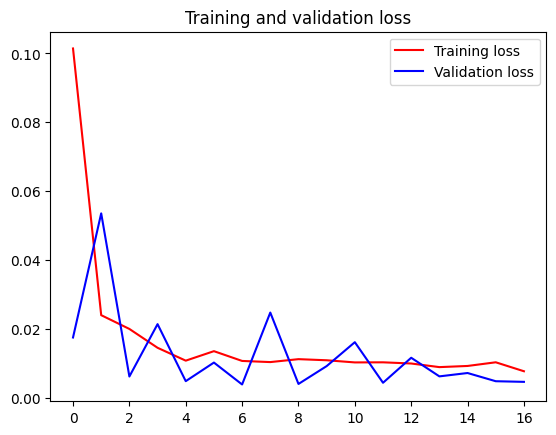

<Figure size 640x480 with 0 Axes>

In [56]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [57]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


((239, 1), (94, 1))

- # Model Evaluation

In [58]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

- ## Evaluation metrices RMSE, MSE and MAE

In [ ]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  4991.037929628816
Train data MSE:  24910459.61499349
Train data MAE:  3910.336901804393
-------------------------------------------------------------------------------------
Test data RMSE:  4099.329457066549
Test data MSE:  16804501.99757353
Test data MAE:  3327.684258643617


- ## Variance Regression Score

In [60]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9134657378349447
Test data explained variance regression score: 0.7714391837507429


- ## R square score for regression

In [61]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9083328843065265
Test data R2 score: 0.7128208302782078


- ## Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [62]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.00379619168578896
Test data MGD:  0.0015971499870745802
----------------------------------------------------------------------
Train data MPD:  302.51503636773356
Test data MPD:  163.1248016796283


- # Comparision of original Bitcoin close price and predicted close price

In [63]:
look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (365, 1)
Test predicted data:  (365, 1)


- # Predicting next 30 days

In [64]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


- # Plotting last 15 days of dataset and next predicted 30 days

In [65]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [66]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()



- # Plotting entire Closing Stock Price with next 30 days period of prediction

In [67]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [69]:
model.save('Model/model.h5')